# SMOTE - Synthetic Minority Oversampling Technique

### Import modules

In [184]:
#Basic
import numpy as np
import pandas as pd

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns

#NLP
from string import punctuation 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Train test split
from sklearn.model_selection import train_test_split

#Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Evaluation
from sklearn.metrics import classification_report


### Instantiate modules

In [406]:
useless = stopwords.words("english")
stemmer = PorterStemmer()
cv = CountVectorizer(min_df=5)
scaler = StandardScaler()
sim = SMOTE(sampling_strategy='minority', random_state=101)

lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors=3)
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=101)
xgb = XGBClassifier(gpu_id=0, max_depth=20, max_leaves=1024)

### Import data

In [186]:
emails = pd.read_csv("SMSSpamCollection.tsv", sep="\t", header=None, names=['label', 'message'])

In [187]:
final = emails.sample(150)

In [188]:
emails = emails.loc[[i for i in emails.index if i not in final.index]]

### Explore data

In [189]:
emails.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [190]:
emails.shape

(5422, 2)

In [191]:
print(round((emails.label.value_counts()/emails.shape[0])*100, 2), '%')

ham     86.63
spam    13.37
Name: label, dtype: float64 %


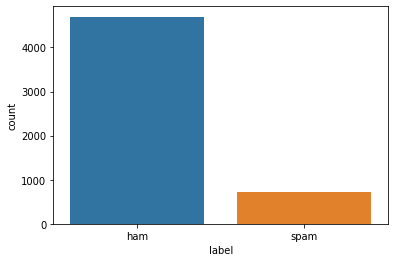

In [192]:
sns.countplot(data=emails, x='label')
plt.show()

### NLP - Preprocessing

In [193]:
def bowords(x):
    bow = ''.join([char for char in x['message'].lower() if char not in list(punctuation)])
    bow = ' '.join([stemmer.stem(word) for word in bow.split() if word not in useless])
    return bow

In [194]:
bag_of_words = emails.apply(bowords, axis=1)

In [195]:
cv.fit(bag_of_words)

CountVectorizer(min_df=5)

In [196]:
corpus = pd.DataFrame(cv.transform(bag_of_words).toarray())

In [197]:
corpus.columns = list(cv.vocabulary_.keys())

### Additional variables

In [198]:
#label 
label = pd.get_dummies(emails.label).drop('ham', axis=1)
#length 
length = emails.apply(lambda x: len(x['message']), axis=1)

### Combine datasets

In [199]:
merged = pd.concat([corpus, pd.DataFrame(length, columns=['len']), label], axis=1)

### Scale features

In [200]:
scaler.fit(merged.drop('spam', axis=1))

StandardScaler()

In [201]:
features = pd.DataFrame(scaler.transform(merged.drop('spam', axis=1)))

In [202]:
features.columns = merged.drop('spam', axis=1).columns

### Oversample using SMOTE

In [205]:
features.dropna(inplace=True)

In [206]:
Xoversampled, yoversampled = sim.fit_resample(features, merged.spam)

### Split data

In [207]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xoversampled, yoversampled, test_size=0.2, random_state=101)

### Train Algorithms

In [407]:
lr.fit(Xtrain, ytrain)

LogisticRegression(max_iter=1000)

In [408]:
dt.fit(Xtrain, ytrain)

DecisionTreeClassifier()

In [409]:
svc.fit(Xtrain, ytrain)

SVC()

In [410]:
knn.fit(Xtrain, ytrain)

KNeighborsClassifier(n_neighbors=3)

In [411]:
rf.fit(Xtrain, ytrain)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=101)

In [412]:
xgb.fit(Xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=1024,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

### Evaluate models

In [413]:
print(classification_report(ytest, lr.predict(Xtest)))

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86       939
         1.0       0.81      0.96      0.88       891

    accuracy                           0.87      1830
   macro avg       0.88      0.87      0.87      1830
weighted avg       0.88      0.87      0.87      1830



In [414]:
print(classification_report(ytest, dt.predict(Xtest)))

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       939
         1.0       0.88      0.89      0.89       891

    accuracy                           0.89      1830
   macro avg       0.89      0.89      0.89      1830
weighted avg       0.89      0.89      0.89      1830



In [415]:
print(classification_report(ytest, svc.predict(Xtest)))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92       939
         1.0       0.90      0.96      0.93       891

    accuracy                           0.92      1830
   macro avg       0.93      0.93      0.92      1830
weighted avg       0.93      0.92      0.92      1830



In [416]:
print(classification_report(ytest, knn.predict(Xtest)))

              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74       939
         1.0       0.70      0.97      0.81       891

    accuracy                           0.78      1830
   macro avg       0.83      0.79      0.78      1830
weighted avg       0.83      0.78      0.78      1830



In [417]:
print(classification_report(ytest, rf.predict(Xtest)))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       939
         1.0       0.95      0.90      0.92       891

    accuracy                           0.93      1830
   macro avg       0.93      0.93      0.93      1830
weighted avg       0.93      0.93      0.93      1830



In [418]:
print(classification_report(ytest, xgb.predict(Xtest)))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91       939
         1.0       0.90      0.92      0.91       891

    accuracy                           0.91      1830
   macro avg       0.91      0.91      0.91      1830
weighted avg       0.91      0.91      0.91      1830



### Reusable components for pipeline

In [419]:
def mytransform(x, vectorizer, punctuation, useless, stemmer):
    def bag_of_words(y):
        bow = ''.join([char for char in y['message'].lower() if char not in list(punctuation)])
        bow = ' '.join([stemmer.stem(word) for word in bow.split() if word not in useless])
        return bow

    length = x.apply(lambda z: len(z['message']), axis=1)
    length.index = range(0,len(x))
    o = x.apply(bag_of_words, axis=1)
    o = pd.DataFrame(vectorizer.transform(o).toarray())
    o.columns = list(vectorizer.vocabulary_.keys())
    p = pd.concat([o, pd.DataFrame(length, columns=['len'])], axis=1)
    columns = p.columns
    out = pd.DataFrame(scaler.transform(p))
    out.columns = columns
    return out

In [287]:
#tfinal = mytransform(final, cv, punctuation, useless, stemmer)
#tfinal.dropna(inplace=True)

In [405]:
print(classification_report(pd.get_dummies(final.label).drop('ham', axis=1).reset_index(drop='index'), rf.predict(tfinal)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       128
           1       0.29      0.09      0.14        22

    accuracy                           0.83       150
   macro avg       0.57      0.53      0.52       150
weighted avg       0.78      0.83      0.79       150



In [302]:
from sklearn.metrics import confusion_matrix

In [326]:
print(confusion_matrix(pd.get_dummies(final.label).drop('ham', axis=1).reset_index(drop='index'), xgb.predict(tfinal)))

[[118  10]
 [ 11  11]]


In [399]:
2**13

8192

In [377]:
accuracy = []
for i in [1, 3, 5, 7, 87, 89]:
    tknn = KNeighborsClassifier(n_neighbors=i)
    tknn.fit(Xtrain, ytrain)
    accuracy.append(accuracy_score(tknn.predict(Xtrain), ytrain))
    

In [341]:
knn.fit(Xtrain, ytrain)

KNeighborsClassifier()

In [351]:
knn.n_samples_fit_

7316

In [357]:
#help(knn)

In [354]:
from sklearn.metrics import accuracy_score